### pip installs needed (just in case of errors)
- pip install tqdm
- pip install pillow
- pip install opencv-python
- pip install scikit-image
- pip install lxml
- pip install regex
- pip install pyts
- pip install numba

# Keyword Spotting on WashingtonDB

In this notebook we implement a simple **query-by-example keyword spotting (KWS)** system on the WashingtonDB dataset.

Given a list of textual **keywords**, our goal is to:

1. **Choose a query example image** for each keyword from the training set.
2. **Compute similarity scores** between this query example and candidate word images from other documents.
3. **Find the best matching occurrence(s)** of the same word in unseen pages.

The workflow is:

1. **Data loading**: we use the precomputed word-level feature files (`train_db.pkl`, `validation_db.pkl`) provided for the exercise.
2. **Keyword medoid prototype**: for each keyword, we collect all its training instances and select the **DTW medoid**, i.e. the instance with minimal average Dynamic Time Warping (DTW) distance to all other instances. This medoid acts as our **query prototype**.
3. **Candidate filtering**: for each prototype we restrict the search to validation words with a **similar length** (±30%) to avoid comparing to obviously wrong candidates.
4. **Similarity computation**:
   - First, we use a cheap **Euclidean distance between mean feature vectors** to quickly filter candidates.
   - Then, on the most promising candidates, we use the more expensive **DTW distance** as our final similarity measure.
5. **Evaluation on validation**: for each keyword we select the **best match** in the validation set and compute a **top-1 keyword match rate** (how often we recover the correct keyword).
6. **Submission file**: we create `submission.csv` for the Kaggle competition, where smaller distances indicate more similar (better) matches.


### Imports and data directory

In [1]:
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm

import DTW as dtw
from DTW_utils import extract_word_images, find_word_image  # only used in the qualitative example

NOTEBOOK_DIR = Path.cwd()
DATA_DIR = NOTEBOOK_DIR
print("Using DATA_DIR =", DATA_DIR)

Using DATA_DIR = C:\Users\MATEO\OneDrive\Personal\UniFR\Pattern Recognition\Group7\PR_group7\KWS


## 1. Load precomputed features and keyword list

We use the provided pickled feature databases:

- `train_features/train_db.pkl`
- `validation_features/validation_db.pkl`

Each entry in these lists is a dictionary:

```python
{
    "loc": "DDD-LL-WW",   # word ID
    "word": "c-a-p-t-a-i-n",
    "features": np.ndarray shape (T, D)  # per-column feature sequence
}

In [2]:
# Load train / validation feature databases
with open(DATA_DIR / "train_features" / "train_db.pkl", "rb") as f:
    train_db = pickle.load(f)

with open(DATA_DIR / "validation_features" / "validation_db.pkl", "rb") as f:
    validation_db = pickle.load(f)

# Load keyword list from TSV (one keyword per line)
keywords = (DATA_DIR / "keywords.tsv").read_text().splitlines()
keywords = [k.strip() for k in keywords if k.strip()]

print(f"Train entries:      {len(train_db)}")
print(f"Validation entries: {len(validation_db)}")
print(f"Keywords:           {len(keywords)}")

Train entries:      2212
Validation entries: 1293
Keywords:           35


## 2. Feature summaries (mean + length)

To speed up candidate selection later, we pre-compute for each word:

- `feat_mean`: mean feature vector over time (shape `(D,)`)
- `length`: number of time steps `T`


In [3]:
def add_summaries(db):
    """Add mean vector and length to each entry in-place."""
    for entry in db:
        feats = entry["features"]                # (T, D)
        entry["feat_mean"] = feats.mean(axis=0).astype("float32")
        entry["length"] = feats.shape[0]         # T

add_summaries(train_db)
add_summaries(validation_db)

print("Example mean shape:", train_db[0]["feat_mean"].shape)
print("Example length:", train_db[0]["length"])

Example mean shape: (7,)
Example length: 219


## 3. Helper functions: keyword instances, DTW distance, medoid

For each keyword we collect all its training instances and compute a **medoid**
(the instance with minimal average DTW distance to the others).

In [4]:
def keyword_instances(db, keyword):
    """Return all entries in db with a given keyword."""
    return [entry for entry in db if entry["word"] == keyword]


def dtw_distance(a_feats, b_feats, win_size=0.2):
    """
    DTW distance between two feature sequences, using the exercise code.

    Parameters
    ----------
    a_feats, b_feats : np.ndarray, shape (T, D)
    win_size : float
        Sakoe–Chiba band parameter (fraction of sequence length).

    Returns
    -------
    float
        DTW distance.
    """
    return float(dtw.DTW(a_feats, b_feats, win_size=win_size))


def keyword_medoid(db, keyword):
    """
    Compute the DTW medoid for a given keyword.

    Returns
    -------
    best_entry : dict
        Representative instance (medoid).
    dist_matrix : np.ndarray, shape (n, n)
        Pairwise DTW distance matrix between all instances.
    """
    instances = keyword_instances(db, keyword)
    n = len(instances)

    if n == 0:
        raise ValueError(f"Keyword '{keyword}' not found in train_db.")

    if n == 1:
        entry = instances[0]
        dist_matrix = np.zeros((1, 1), dtype=float)
        return entry, dist_matrix

    dist_matrix = np.zeros((n, n), dtype=float)

    for i in range(n):
        for j in range(i + 1, n):
            d = dtw_distance(instances[i]["features"],
                             instances[j]["features"])
            dist_matrix[i, j] = d
            dist_matrix[j, i] = d

    sums = dist_matrix.sum(axis=1)
    best_idx = int(np.argmin(sums))
    best_entry = instances[best_idx]

    return best_entry, dist_matrix

## 4. Build a DTW medoid prototype per keyword

For each keyword in `keywords.tsv` we:

1. Collect all its training instances.
2. Compute the medoid using DTW distances.
3. Store the medoid in a `prototypes` dictionary.
4. Log basic statistics: support and mean intra-class distance.

In [5]:
prototypes = {}
stats = []

for word in tqdm(keywords, desc="Building prototypes"):
    try:
        proto, dist_matrix = keyword_medoid(train_db, word)
        prototypes[word] = proto

        stats.append({
            "keyword": word,
            "support": len(keyword_instances(train_db, word)),
            "mean_intra_distance": float(dist_matrix.mean())
                                   if dist_matrix.size > 1 else 0.0,
        })
    except ValueError as e:
        print("WARNING:", e)

medoid_df = pd.DataFrame(stats).sort_values("support", ascending=False)
medoid_df.head()

Building prototypes:  46%|███████████████████████████▉                                 | 16/35 [00:08<00:07,  2.50it/s]

Building prototypes: 100%|█████████████████████████████████████████████████████████████| 35/35 [00:23<00:00,  1.52it/s]


keyword  support  mean_intra_distance
19  C-a-p-t-a-i-n       16            48.376795
27        F-o-r-t       14            37.984204
26    s_et-c-s_pt       13            20.804661
18    O-r-d-e-r-s       12            53.710514
28          m-e-n       12            46.850003

The table above shows, for each keyword:

- `support`: number of training instances (how many times it appears in the training set),
- `mean_intra_distance`: average DTW distance between instances of this keyword.

Keywords with higher support and lower intra-distance are easier to model; rare keywords with large intra-distance are usually harder.


## 5. Keyword spotting on the validation set

For each keyword:

1. Take its medoid prototype from `prototypes`.
2. Filter validation candidates by **word length** (±30%).
3. Rank remaining candidates by Euclidean distance between `feat_mean`.
4. Keep the top `K` candidates and run **DTW** on these only.
5. Keep the best match (smallest DTW distance).

This balances accuracy and runtime.

In [6]:
from numpy.linalg import norm

L_TOL = 0.30            # allow ±30% relative length difference
TOP_K = 200             # number of best Euclidean candidates to re-score with DTW
N_BEST_MATCHES = 20     # number of best DTW matches to keep for visualization

predictions = []        # list of (best_dist, best_loc, best_word, keyword)
all_top_matches = {}    # dict to store top N-best matches for each keyword

for kw in tqdm(keywords, desc="Searching validation (DTW + filter)"):
    proto = prototypes.get(kw)
    if proto is None:
        print(f"Skipping '{kw}' - no prototype.")
        continue

    proto_vec = proto["feat_mean"]
    proto_len = proto["length"]

    # 1) Candidate filter by length
    min_len = int((1.0 - L_TOL) * proto_len)
    max_len = int((1.0 + L_TOL) * proto_len)

    candidates = []
    for entry in validation_db:
        L = entry["length"]
        if L < min_len or L > max_len:
            continue
        d_mean = float(norm(proto_vec - entry["feat_mean"]))
        candidates.append((d_mean, entry))

    # Fallback: if length filter removes everything, use all validation words
    if not candidates:
        for entry in validation_db:
            d_mean = float(norm(proto_vec - entry["feat_mean"]))
            candidates.append((d_mean, entry))

    # 2) Sort by mean distance and keep TOP_K best
    candidates.sort(key=lambda x: x[0])
    candidates = [e for _, e in candidates[:TOP_K]]

    # 3) Among candidates, use DTW for final distance
    best_dist = float("inf")
    best_loc = None
    best_word = None

    dtw_matches = []  # stores all DTW results for this keyword

    for entry in candidates:
        d = dtw_distance(proto["features"], entry["features"], win_size=0.2)
        if d < best_dist:
            best_dist = d
            best_loc = entry["loc"]
            best_word = entry["word"]

        # Check if current entry matches keyword and store its DTW results
        is_correct = (entry["word"] == kw)
        dtw_matches.append((d, entry["loc"], entry["word"], is_correct))
    
    predictions.append((best_dist, best_loc, best_word, kw))

    # Sort all scores from DTW matches and keep the N-best matches for visualization
    dtw_matches.sort(key=lambda x: x[0])
    all_top_matches[kw] = dtw_matches[:N_BEST_MATCHES]

len(predictions), predictions[:3]

Searching validation (DTW + filter):  37%|████████████████▋                            | 13/35 [02:01<03:10,  8.67s/it]

Skipping 'h-u-n-d-r-e-d' - no prototype.


Searching validation (DTW + filter): 100%|█████████████████████████████████████████████| 35/35 [04:10<00:00,  7.16s/it]


(34,
 [(39.63474733541498, '304-23-01', 'a-b-o-v-e-s_cm', 'c-a-r-e-f-u-l'),
  (54.05357317351873, '302-22-05', 'm-e-n', 'R-e-g-i-m-e-n-t'),
  (36.25758829975285, '304-35-07', 'w-i-l-l', 'M-r-s_pt')])

## 6. Simple validation metric
Here we compute the **top-1 exact match rate**,
i.e. the fraction of keywords for which the best validation match has the
correct keyword label.

In [7]:
# Evaluation: how well do we spot keywords on the validation set?

matches = 0
total   = 0

rows = []

# Count how many keywords actually got a prototype
n_keywords_total   = len(keywords)
n_keywords_protot  = 0

for best_dist, best_loc, best_word, kw in predictions:
    if best_loc is None:
        # this would be the case if something went wrong for a keyword
        continue

    total += 1
    if best_word == kw:
        matches += 1

    rows.append({
        "location": best_loc,
        "word": best_word,
        "distance": best_dist,
        "keyword": kw,
    })

# Any keyword that appears in predictions had a prototype
keywords_with_prototype = {kw for _, _, _, kw in predictions if kw is not None}
n_keywords_protot = len(keywords_with_prototype)

top1_rate = matches / total if total > 0 else 0.0

print(f"Top-1 exact keyword match rate on validation: {top1_rate:.3f}")
print(f"Keywords with at least one prototype: {n_keywords_protot}/{n_keywords_total}")

results_df = pd.DataFrame(rows)
display(results_df.head())

Top-1 exact keyword match rate on validation: 0.324
Keywords with at least one prototype: 34/35


location             word   distance                keyword
0  304-23-01   a-b-o-v-e-s_cm  39.634747          c-a-r-e-f-u-l
1  302-22-05            m-e-n  54.053573        R-e-g-i-m-e-n-t
2  304-35-07          w-i-l-l  36.257588               M-r-s_pt
3  304-32-02  O-f-f-i-c-e-r-s  50.360871        O-f-f-i-c-e-r-s
4  303-16-09    C-a-p-t-a-i-n  58.307667  o-p-p-o-r-t-u-n-i-t-y

### How do we “calculate similarity to all words”?
Our implementation therefore uses a **two-stage approximation**:

1. **Length filter**  
   We restrict the candidates to word images whose sequence length is within ±30% of the prototype’s length.  
   If this filter removes all candidates (very rare), we fall back to all validation words.

2. **Approximate + exact distance**  
   - First we compute a fast **Euclidean distance** between the **mean feature vectors** of prototype and candidate.  
   - Then we compute **DTW distance** for all remaining candidates and keep the one with the smallest DTW cost as the best match.

So conceptually we still compare the prototype to **all words**, but we:
- quickly discard obviously bad candidates using length and Euclidean distance, and use **DTW only where it matters**

## 7. Build `submission.csv` for Kaggle

For each detected match we output:

- `location`: word ID (`DDD-LL-WW`)
- `word`: the **keyword** for which we computed the dissimilarity
- `distance`: the DTW distance (smaller = better match)

In [8]:
rows = []
for dist, loc, val_word, kw in predictions:
    rows.append({
        "location": loc,
        "word": kw,
        "distance": float(dist),
    })

submission = pd.DataFrame(rows)
print(submission.head())

out_path = DATA_DIR / "submission.csv"
submission.to_csv(out_path, index=False)
print("Saved submission to:", out_path)

    location                   word   distance
0  304-23-01          c-a-r-e-f-u-l  39.634747
1  302-22-05        R-e-g-i-m-e-n-t  54.053573
2  304-35-07               M-r-s_pt  36.257588
3  304-32-02        O-f-f-i-c-e-r-s  50.360871
4  303-16-09  o-p-p-o-r-t-u-n-i-t-y  58.307667
Saved submission to: C:\Users\MATEO\OneDrive\Personal\UniFR\Pattern Recognition\Group7\PR_group7\KWS\submission.csv


## Summary 

Our simple KWS system achieves a **top-1 keyword match rate of about 0.32** on the validation set.  
This means that for roughly one third of the keywords, the closest match in the validation set (according to our DTW-based similarity) is an occurrence of the **correct keyword**.

### Visualization of Results

The following plot visualizes the best matches for each keyword in separate rows.  

The first column displays the medoid prototype of the keyword where one was available.  
Additionally, the number of occurrences of this keyword within the training and validation sets are shown.  

In the subsequent columns, the 1st to 6th best match for the medoid prototype within the validation set are displayed.  
For each match, it also lists its keyword, its location (DDD-LL-WW) and DTW result.  
Green backgrounds highlight the cases where correct matches have occurred, with top-1 matches being colored slightly darker.  

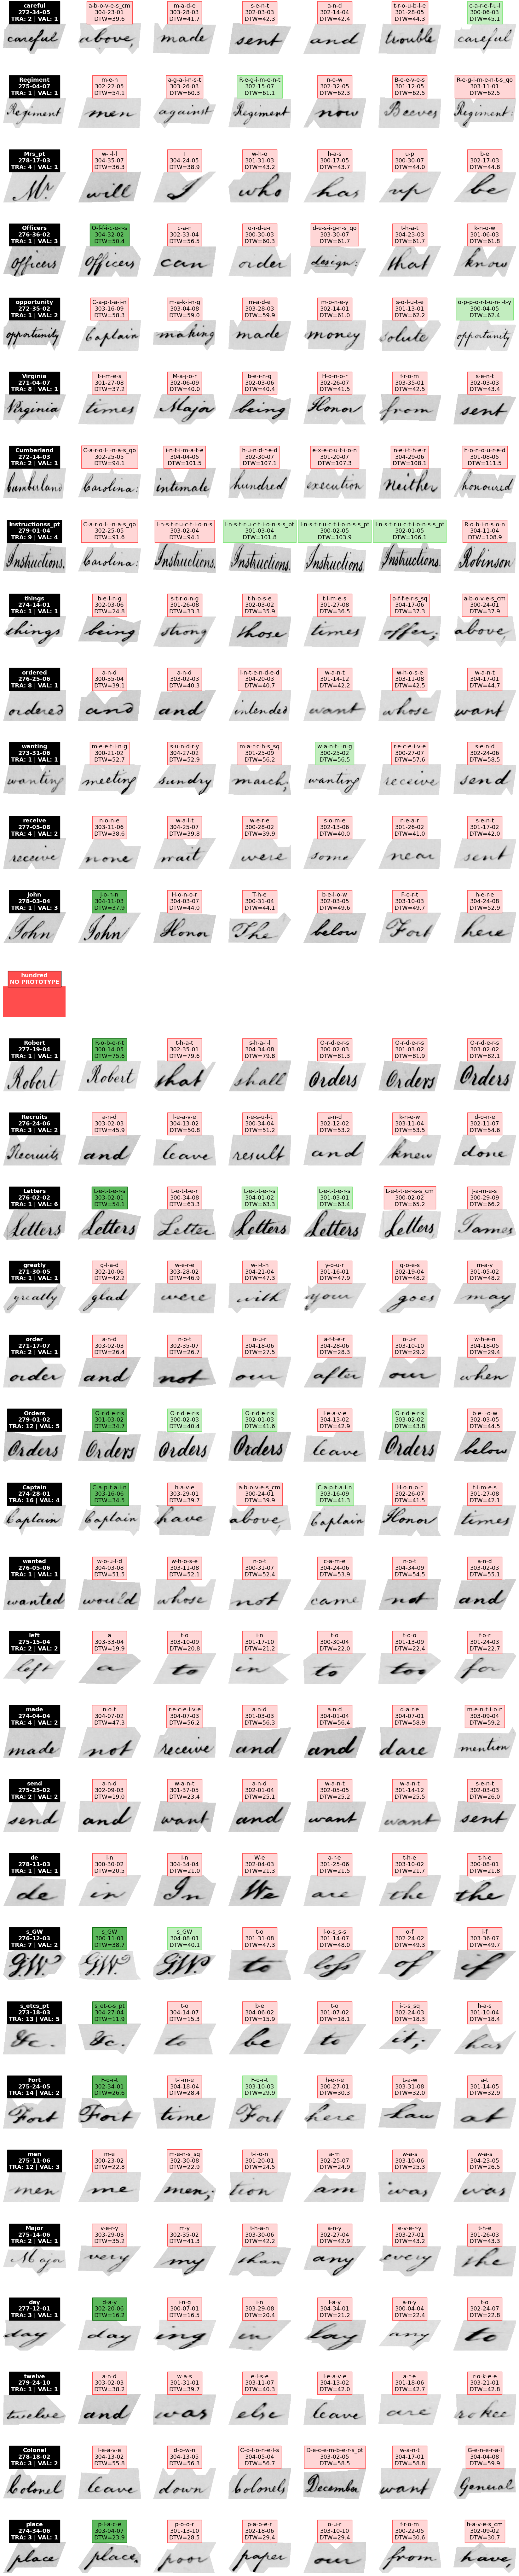

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# PARAMETER: Define the number of best matches to display per keyword (must be <=20)
nbo_matches = 6


# Create plot structure according to number of keywords and best matches to display
fig, axes = plt.subplots(
    len(keywords), nbo_matches + 1,
    figsize=(3 * (nbo_matches + 1), 3 * len(keywords)),
    gridspec_kw={'hspace': 1.4}
)

# Iterate through all keywords and visualize their results
for row_idx, keyword in enumerate(keywords):

    # Get best matches for current keyword from earlier calculations
    matches = all_top_matches.get(keyword, [])
    
    # Calculate the number of occurrences the current keyword has in the training and validation sets
    n_train = sum(1 for entry in train_db if entry["word"] == keyword)
    n_val = sum(1 for entry in validation_db if entry["word"] == keyword)


    #######################################
    # PROTOTYPE
    #######################################

    # Get prototype of current keyword
    prototype = prototypes.get(keyword, None)

    # Get new axis for current prototype
    ax = axes[row_idx][0]
    
    # Check if current keyword has a prototype
    if prototype is not None:

        # CASE: Keyword has prototype
        #########################################

        # Add text box in black color with white text showing keyword, location and number of training + validation samples
        ax.add_patch(patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes, facecolor="#e0e0e0"))
        title = f"{keyword.replace('-', '')}\n{prototype['loc']}\nTRA: {n_train} | VAL: {n_val}"
        title_kwargs = dict(bbox=dict(facecolor="black"), color="white", fontsize=13, fontweight="bold")

        # Open and display prototype image
        img = Image.open(f"train_words/{prototype['loc']}.png")
        ax.imshow(img, zorder=1, aspect='auto')

    else:

        # CASE: Keyword has no prototype
        #########################################

        # Add text box in red color with white text showing "NO PROTOTYPE" available
        ax.add_patch(patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes, facecolor="#ff4d4d"))
        title = f"{keyword.replace('-', '')}\nNO PROTOTYPE"
        title_kwargs = dict(bbox=dict(facecolor="#ff4d4d"), color="white", fontsize=13, fontweight="bold")
    

    # Show description text box and hide plot axes
    ax.set_title(title, **title_kwargs)
    ax.axis("off")


    #######################################
    # BEST MATCHES
    #######################################

    # Display the specified number of best matches
    for i in range(nbo_matches):

        # Get new axis for current match
        ax = axes[row_idx][i + 1]

        # Handle cases where there are less matches than slots to display (e.g. no prototype)
        if i >= len(matches): 
            ax.axis("off") 
            continue

        # Get properties of current match incl. DTW result, location (DDD-LL-WW), keyword and correctness
        dist, loc, word, is_correct = matches[i]

        # Define text box colors depending of correctness of match
        if is_correct:
            bgcolor = "#5cb85c" if i == 0 else "#c2edbf"
            edgecolor = "#0c6d0c" if i == 0 else "#80e679"
        else:
            bgcolor = "#ffd6d6"
            edgecolor = "#ff4d4d"

        # Add text box with suitable colors based on match showing keyword, location and DTW result
        ax.add_patch(patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes, zorder=0, facecolor=bgcolor, edgecolor=edgecolor, linewidth=3))
        title = f"{word}\n{loc}\nDTW={dist:.1f}"
        title_kwargs = dict(bbox=dict(facecolor=bgcolor, edgecolor=edgecolor), fontsize=13)

        # Show description text box and hide plot axes
        ax.set_title(title, **title_kwargs)
        ax.axis("off")

        # Open and display best match image
        img = Image.open(f"validation_words/{loc}.png")
        ax.imshow(img, zorder=1, aspect='auto')
        
plt.show()